# Comparison of Clustering Algorithms for Classifying Breast Cancer Types Based on Proteome Data

In [133]:
%matplotlib inline

In [168]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn import metrics
import re
from sklearn.preprocessing import Imputer
from numpy import random
import seaborn as sb

# Data Pre-processing

In [135]:
dataset_path = "77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "clinical_data_breast_cancer.csv"
pam50_proteins = "PAM50_proteins.csv"

In [136]:
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

data.shape # 12553 genes × 85 samples
clinical.shape # 105 sampels x 29 clinical features
pam50 # the 50 genes associated with breast cancer 

GeneSymbol RefSeqProteinID       Species  \
0         MIA       NP_006524  Homo sapiens   
1       FGFR4       NP_002002  Homo sapiens   
2       FGFR4       NP_998812  Homo sapiens   
3       FGFR4       NP_075252  Homo sapiens   
4      GPR160       NP_055188  Homo sapiens   
5      ACTR3B       NP_065178  Homo sapiens   
6      ACTR3B    NP_001035225  Homo sapiens   
7        MLPH    NP_001035932  Homo sapiens   
8        MLPH       NP_077006  Homo sapiens   
9       ERBB2    NP_001005862  Homo sapiens   
10      ERBB2       NP_004439  Homo sapiens   
11       ANLN       NP_061155  Homo sapiens   
12      PTTG1       NP_004210  Homo sapiens   
13      PTTG1       NP_006598  Homo sapiens   
14      CEP55       NP_060601  Homo sapiens   
15      CEP55    NP_001120654  Homo sapiens   
16      CXXC5       NP_057547  Homo sapiens   
17      MYBL2       NP_002457  Homo sapiens   
18       CDH3       NP_001784  Homo sapiens   
19        PGR       NP_000917  Homo sapiens   
20      CCNE1       NP_001229  Homo sapiens   
21      CCNE1       NP_476530  Homo sapiens   
22      KIF2C       NP_006836  Homo sapiens   
23       TYMS       NP_001062  Homo sapiens   
24       KRT5       NP_000415  Homo sapiens   
25       BAG1       NP_004314  Homo sapiens   
26       MAPT       NP_058525  Homo sapiens   
27       MAPT    NP_001116538  Homo sapiens   
28       MAPT    NP_001116539  Homo sapiens   
29       MAPT       NP_005901  Homo sapiens   
..        ...             ...           ...   
70      NDC80       NP_006092  Homo sapiens   
71      UBE2C       NP_861515  Homo sapiens   
72      UBE2C       NP_861518  Homo sapiens   
73      UBE2C       NP_008950  Homo sapiens   
74      UBE2C       NP_861519  Homo sapiens   
75      UBE2C       NP_861516  Homo sapiens   
76      UBE2C       NP_861517  Homo sapiens   
77      MMP11       NP_005931  Homo sapiens   
78      CCNB1       NP_114172  Homo sapiens   
79      BLVRA       NP_000703  Homo sapiens   
80      KRT17       NP_000413  Homo sapiens   
81      SFRP1       NP_003003  Homo sapiens   
82       RRM2       NP_001025  Homo sapiens   
83       RRM2    NP_001159403  Homo sapiens   
84      KRT14       NP_000517  Homo sapiens   
85      PHGDH       NP_006614  Homo sapiens   
86       MDM2    NP_001138811  Homo sapiens   
87       MDM2    NP_001138812  Homo sapiens   
88       MDM2       NP_006872  Homo sapiens   
89       MDM2       NP_006873  Homo sapiens   
90       MDM2       NP_006870  Homo sapiens   
91       MDM2    NP_001138808  Homo sapiens   
92       MDM2    NP_001138809  Homo sapiens   
93       MDM2       NP_006869  Homo sapiens   
94       MDM2       NP_002383  Homo sapiens   
95      FOXC1       NP_001444  Homo sapiens   
96       GRB7    NP_001025173  Homo sapiens   
97       GRB7       NP_005301  Homo sapiens   
98       MELK       NP_055606  Homo sapiens   
99      UBE2T       NP_054895  Homo sapiens   

                                            Gene Name  
0                        melanoma inhibitory activity  
1                 fibroblast growth factor receptor 4  
2                 fibroblast growth factor receptor 4  
3                 fibroblast growth factor receptor 4  
4                      G protein-coupled receptor 160  
5      ARP3 actin-related protein 3 homolog B (yeast)  
6      ARP3 actin-related protein 3 homolog B (yeast)  
7                                        melanophilin  
8                                        melanophilin  
9   v-erb-b2 erythroblastic leukemia viral oncogen...  
10  v-erb-b2 erythroblastic leukemia viral oncogen...  
11                                            anillin  
12  pituitary tumor-transforming 1; pituitary tumo...  
13  pituitary tumor-transforming 1; pituitary tumo...  
14                          centrosomal protein 55kDa  
15                          centrosomal protein 55kDa  
16                                      CXXC finger 5  
17  v-myb myeloblastosis viral oncogene homolog (a...  
18                      

In [137]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)
 
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
data = data.transpose()

## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]
 
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = data.merge(clinical,left_index=True,right_index=True)
 
## Change name to make it look nicer in the code!
processed = merged
 
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]
 
## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_numerical_p50 = processed_numerical.ix[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]

## Impute missing values (maybe another method would work better?)
imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
imputer = imputer.fit(processed_numerical_p50)
processed_numerical_p50_imputed = imputer.transform(processed_numerical_p50)

processed_numerical_p50_imputed = pd.DataFrame(processed_numerical_p50_imputed, \
                                               columns = processed_numerical_p50.columns, \
                                               index = processed_numerical_p50.index)

In [138]:
processed_numerical_p50_imputed

RefSeq_accession_number  NP_057427  NP_002408  NP_000415  NP_000413  \
TCGA-A2-A0CM              2.160157   2.623021   4.768355   0.639321   
TCGA-A2-A0D2              2.249702   3.576941   2.169868   2.968207   
TCGA-A2-A0EQ             -0.020957   1.884936  -7.407249  -7.675146   
TCGA-A2-A0EV             -1.364604  -2.246793  -3.750716  -3.882344   
TCGA-A2-A0EX             -2.506723  -2.953194  -0.803378  -2.315378   
TCGA-A2-A0EY             -1.015330  -0.840446  -3.059805  -3.638587   
TCGA-A2-A0SW              0.293752   0.039676  -5.945578  -3.610654   
TCGA-A2-A0SX              1.457488   1.385987   5.625404   3.271828   
TCGA-A2-A0T3              1.059592  -0.451477  -0.355684   0.305602   
TCGA-A2-A0T6             -2.885329  -3.435150  -2.781589  -3.189632   
TCGA-A2-A0YC             -0.270496  -1.509796  -1.722924  -1.371657   
TCGA-A2-A0YD             -1.632842  -2.897917  -0.831824  -0.740195   
TCGA-A2-A0YF             -1.399735  -1.513301  -1.183961  -1.346738   
TCGA-A2-A0YG              0.090860   1.294577  -2.806853  -5.051989   
TCGA-A2-A0YM              0.000077  -1.320640   0.291277  -0.534171   
TCGA-A7-A0CE              1.761673  -0.583448   5.542903   6.038440   
TCGA-A7-A0CJ             -0.683522  -2.461391  -3.644384  -3.286106   
TCGA-A7-A13F              0.736809   0.371208  -1.336271  -2.308530   
TCGA-A8-A06N             -0.358817   0.269542  -3.695040  -3.438625   
TCGA-A8-A06Z              0.717278  -0.059650  -1.185145  -1.605106   
TCGA-A8-A076             -0.969020  -1.991062  -5.856105  -4.693713   
TCGA-A8-A079              2.430691   0.705999  -5.562909  -4.316382   
TCGA-A8-A08Z             -0.409160  -2.619637  -5.922812  -4.127919   
TCGA-A8-A09G             -1.183705  -1.312072  -2.614465  -2.199946   
TCGA-AN-A04A             -1.010773   0.315315   2.403407   3.544766   
TCGA-AN-A0AJ              1.480831  -0.471788  -4.539342  -3.936113   
TCGA-AN-A0AL             -0.632908   3.858672  -4.495600  -0.411143   
TCGA-AN-A0AM             -0.505383  -0.731681  -5.408514  -6.045502   
TCGA-AN-A0FK             -1.381394  -4.620440  -3.169129  -3.341252   
TCGA-AN-A0FL             -0.342447   0.696137  -4.069530  -3.878630   
...                            ...        ...        ...        ...   
TCGA-AR-A1AP             -2.509488  -3.610008  -2.575685  -1.950954   
TCGA-AR-A1AS             -0.565545  -0.781101  -2.215783  -2.689299   
TCGA-AR-A1AV              1.882713   0.999190  -3.354167  -4.738353   
TCGA-AR-A1AW             -2.306877  -1.650976  -5.469260  -7.948412   
TCGA-BH-A0AV             -0.671766   0.418014   1.119792   1.727100   
TCGA-BH-A0BV             -1.358787  -3.278318  -2.701464  -0.430516   
TCGA-BH-A0C1              0.036479   1.408256  -3.886471  -5.726661   
TCGA-BH-A0C7              0.944990  -0.918145  -1.125656  -0.244293   
TCGA-BH-A0DD              1.189354  -1.680075  -4.047413  -2.822685   
TCGA-BH-A0DG             -0.706863   0.365854  -2.224594  -2.931932   
TCGA-BH-A0E1              1.078860  -0.956573  -1.295089  -2.024200   
TCGA-BH-A0E9             -0.516858  -2.851793   4.855835   5.738269   
TCGA-BH-A18N             -0.649157  -3.465198  -3.507124  -6.389548   
TCGA-BH-A18Q             -0.179342  -1.463969   2.182497   2.319658   
TCGA-BH-A18U             -0.375482  -1.951926  -5.195184  -4.221202   
TCGA-C8-A12L              0.179349  -0.692468   1.607704  -0.072875   
TCGA-C8-A12T              0.203077  -0.451415   0.534572  -0.502414   
TCGA-C8-A12U              0.126063   0.437190  -4.983742  -4.189453   
TCGA-C8-A12V              0.185080   2.695860   0.781298  -4.258777   
TCGA-C8-A12Z             -2.153013  -2.012368  -5.109682  -4.803388   
TCGA-C8-A130              0.106156   1.883845  -2.639094  -1.976560   
TCGA-C8-A131              0.764109   1.743696   0.658864   2.496602   
TCGA-C8-A131              0.922474   1.545247   0.478179   1.511071   
TCGA-C8-A134              2.241728   1.023184   3.753428   3.566231   
TCGA-C8-A135            

In [186]:
processed_numerical_p50_imputed = np.array(processed_numerical_p50_imputed)
pca = PCA(n_components=10)
pca.fit(processed_numerical_p50_imputed)
explained_var = np.array([round(i*100,1) for i in pca.explained_variance_ratio_])
print 'Percent variance explained by top 10 components:'
pd.DataFrame(explained_var.T, columns = ["% Variance Explained"], index = ["PC"+str(i) for i in range(1,11)]).T

Percent variance explained by top 10 components:


PC1   PC2  PC3  PC4  PC5  PC6  PC7  PC8  PC9  PC10
% Variance Explained  43.6  15.5   10  7.2  6.3    5  3.6  3.4  2.7   2.6

In [193]:
processed_numerical_p50_imputed = pca.fit_transform(processed_numerical_p50_imputed)
pd.DataFrame(processed_numerical_p50_imputed, index = processed_numerical_p50.index, columns = ["PC"+str(i) for i in range(1,11)])

PC1        PC2        PC3        PC4       PC5       PC6  \
TCGA-A2-A0CM  15.452215  -8.091663   3.617109  -0.056361  0.406466 -3.306344   
TCGA-A2-A0D2  17.603743  -9.927058   2.331730  -4.521283 -3.775724  3.290489   
TCGA-A2-A0EQ  11.227661  11.968896   3.754588   0.140442 -2.780364 -4.155884   
TCGA-A2-A0EV  -3.593544   3.710288  -8.282789  -3.636974 -4.162123  1.472930   
TCGA-A2-A0EX -10.667292  -3.714874  -4.673912  -3.541078  5.214026  1.336807   
TCGA-A2-A0EY   5.395052   9.489022  -3.204491   4.226304  6.802382 -1.669925   
TCGA-A2-A0SW  -0.382183   1.277285   3.417598  -1.060747 -2.547052 -1.309131   
TCGA-A2-A0SX  10.972608  -8.747986  -2.886030  -3.399010  1.725154 -2.148110   
TCGA-A2-A0T3  -4.421977  -7.906131   1.775254  -2.370331  0.110986  1.734606   
TCGA-A2-A0T6  -7.520190   1.711841 -10.119555   0.355065 -1.694989 -1.979231   
TCGA-A2-A0YC -14.595687  -5.691170   0.169368   0.831652 -0.987906  0.177719   
TCGA-A2-A0YD  -3.305121  -2.085677  -5.914665   2.560612 -4.869045 -0.075911   
TCGA-A2-A0YF  -6.361398  -0.725953  -3.029779   4.668395  1.795059 -6.717770   
TCGA-A2-A0YG   1.006214   2.380347   4.997449   9.293988 -1.139447  5.007892   
TCGA-A2-A0YM   5.010998  -4.650849  -2.857571  -2.353875 -0.741662  0.885561   
TCGA-A7-A0CE  11.406982 -12.057984  -0.087223   0.714714 -0.524162  2.814690   
TCGA-A7-A0CJ  -8.287531  -0.039580   1.526446  -0.959390 -4.529190 -2.405716   
TCGA-A7-A13F  -2.161131  -1.323397   3.818511   6.749569 -0.990825 -5.019619   
TCGA-A8-A06N  -5.432875   5.056344   0.431051   0.867309  1.529370 -4.631529   
TCGA-A8-A06Z  -8.927162  -6.586819   4.145640   1.842218  1.411773  0.496617   
TCGA-A8-A076  -0.038297   8.815921   1.434299   2.023199  3.457418  1.545635   
TCGA-A8-A079  -7.780449  -2.015699  12.469397   1.868301 -3.544352  0.981240   
TCGA-A8-A08Z -11.700253   0.416597   1.041126  -5.476700 -0.174396  2.262671   
TCGA-A8-A09G   4.882639   6.160096  -1.866458   0.312553  6.664774 -0.126915   
TCGA-AN-A04A  -6.294556  -7.449069  -2.388179   5.890229  7.622934 -4.361425   
TCGA-AN-A0AJ  -2.751260   0.707535   4.193099  -1.393119 -3.369742  4.200839   
TCGA-AN-A0AL  12.827973  -0.677951   3.700042  -0.907321  1.925666  0.346576   
TCGA-AN-A0AM   6.822563   9.177090   2.713759  -3.501637 -4.797293 -3.442212   
TCGA-AN-A0FK -17.270235  -0.441021  -5.148042   2.058404 -2.753485 -0.685467   
TCGA-AN-A0FL   8.705828   1.971478  -1.785339  -1.269368 -1.537040  1.047084   
...                 ...        ...        ...        ...       ...       ...   
TCGA-AR-A1AP  -3.731594   0.629726  -5.144032  -1.934400  1.554191 -1.756476   
TCGA-AR-A1AS -11.083669  -4.676032   2.419856  -3.858203  2.868786  1.955672   
TCGA-AR-A1AV  -9.453150   0.189177   2.349730   0.919141 -1.224405  3.019823   
TCGA-AR-A1AW -11.905457   3.471905   2.916395  -8.111516 -0.679852  2.413918   
TCGA-BH-A0AV   8.787815  -4.233844  -6.882508  -0.395221  0.606157  2.114938   
TCGA-BH-A0BV  -3.226202  -0.420976  -3.386350  -3.590530  2.237392 -3.190254   
TCGA-BH-A0C1  15.049023   5.677873   4.322308  -4.690275 -1.642333 -1.675774   
TCGA-BH-A0C7  -5.603709  -6.261167   2.163073   1.000604 -0.116043  1.378358   
TCGA-BH-A0DD  -6.091806  -3.410250   7.282696   5.582663 -6.143410  6.366212   
TCGA-BH-A0DG   5.795248   4.574788  -2.746993   2.699360 -1.323759 -7.104858   
TCGA-BH-A0E1   1.126312  -3.541274  -1.877689   7.102701 -7.233898 -1.192122   
TCGA-BH-A0E9  -2.552732 -12.575601  -8.810369   5.623021  1.858079 -0.787897   
TCGA-BH-A18N -15.214171   1.206193  -0.244346  -4.743023  1.854705  0.743557   
TCGA-BH-A18Q  14.959905  -4.239662  -8.935678  -2.234016 -2.034425 -1.805887   
TCGA-BH-A18U   0.025490   6.542599  -0.893398  10.138551 -5.929787  2.955303   
TCGA-C8-A12L   8.678265  -2.066158   2.086874   1.970159  2.360742  0.866523   
TCGA-C8-A12T   1.103145  -3.739313   0.692181   6.012751 -1.799739  2.829129   
TCGA-C8-A12U   0.774636   0.594520   6.547418  -1.892126 -1.213632 -2.464826   
TCGA-C8-A12V  16.293

# K-Means

In [194]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6]
 
def compare_k_means(k_list,data):
    ## Run clustering with different k and check the metrics
    s_scores, h_scores, r_scores = [], [], []
    
    for k in k_list:
        clusterer = KMeans(n_clusters=k, n_jobs=4, max_iter = 10)
        clusterer.fit(data)
        silhouette = metrics.silhouette_score(data, clusterer.labels_)
        homogeneity = metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_)
        rand = metrics.adjusted_rand_score(processed['PAM50 mRNA'], clusterer.labels_)

        s_scores.append(silhouette)
        h_scores.append(homogeneity)
        r_scores.append(rand)
        
        ## The higher (up to 1) the better
        print "------------ k=",k, "--------"
        print "Silhouette Coefficient:", round(silhouette, 4)
        ## The higher (up to 1) the better
        print "Homogeneity score:", round(homogeneity,4)
        ## The higher (up to 1) the better
        print "Adjusted Rand Index", round(rand,4)
        print 
        
    return s_scores, h_scores, r_scores
 
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)
 
 
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
s_scores, h_scores, r_scores = compare_k_means(n_clusters,processed_numerical_p50_imputed)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
# compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

print
print("------------Results------------")

print "k with highest silhouette coefficient:", n_clusters[np.array(s_scores).argmax()], np.max(s_scores)
print "k with highest homogeneity score:", n_clusters[np.array(h_scores).argmax()], np.max(h_scores)
print "k with adjusted rand index score:", n_clusters[np.array(r_scores).argmax()], np.max(r_scores)

------------ k= 2 --------
Silhouette Coefficient: 0.2537
Homogeneity score: 0.2073
Adjusted Rand Index 0.2213

------------ k= 3 --------
Silhouette Coefficient: 0.2252
Homogeneity score: 0.4125
Adjusted Rand Index 0.3781

------------ k= 4 --------
Silhouette Coefficient: 0.187
Homogeneity score: 0.4387
Adjusted Rand Index 0.3498

------------ k= 5 --------
Silhouette Coefficient: 0.1904
Homogeneity score: 0.5422
Adjusted Rand Index 0.3903

------------ k= 6 --------
Silhouette Coefficient: 0.1711
Homogeneity score: 0.5174
Adjusted Rand Index 0.3334


------------Results------------
k with highest silhouette coefficient: 2 0.25371127879
k with highest homogeneity score: 5 0.54224973226
k with adjusted rand index score: 5 0.390316395341


In [197]:
kmean_metrics = np.array([s_scores, h_scores, r_scores])
pd.DataFrame(kmean_metrics, columns=["k = "+str(k) for k in n_clusters], index=["Silhouette Coeff.", "Homogeneity Score", "Adjusted Rand Index"])

k = 2     k = 3     k = 4     k = 5     k = 6
Silhouette Coeff.    0.253711  0.225192  0.187039  0.190362  0.171070
Homogeneity Score    0.207323  0.412465  0.438705  0.542250  0.517408
Adjusted Rand Index  0.221339  0.378115  0.349754  0.390316  0.333428

/Users/RichardChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


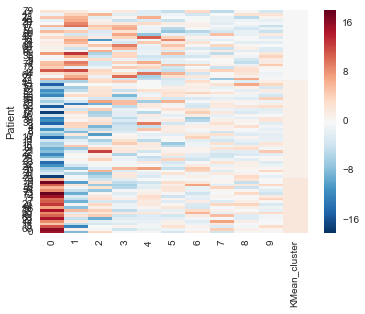

In [195]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
kmean_final = KMeans(n_clusters=3, max_iter=10)
kmean_final = kmean_final.fit(processed_numerical_p50_imputed)
kmean_plot = pd.DataFrame(processed_numerical_p50_imputed)
kmean_plot['KMean_cluster'] = kmean_final.labels_
kmean_plot.sort('KMean_cluster',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
kmean_plot.index.name = 'Patient'
sb.heatmap(kmean_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!
 
## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!

# Spectral Clustering

In [209]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6]
 
def compare_spectral(k_list,data):
    ## Run clustering with different k and check the metrics
    s_scores, h_scores, r_scores = [], [], []
    
    for k in k_list:
        clusterer = SpectralClustering(n_clusters=k, gamma = .10, n_jobs=4)
        clusterer.fit(data)
        silhouette = metrics.silhouette_score(data, clusterer.labels_)
        homogeneity = metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_)
        rand = metrics.adjusted_rand_score(processed['PAM50 mRNA'], clusterer.labels_)

        s_scores.append(silhouette)
        h_scores.append(homogeneity)
        r_scores.append(rand)
        
        ## The higher (up to 1) the better
        print "------------ k=",k, "--------"
        print "Silhouette Coefficient:", round(silhouette, 4)
        ## The higher (up to 1) the better
        print "Homogeneity score:", round(homogeneity,4)
        ## The higher (up to 1) the better
        print "Adjusted Rand Index", round(rand,4)
        print 
        
    return s_scores, h_scores, r_scores
 
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)
 
 
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
s_scores, h_scores, r_scores = compare_spectral(n_clusters,processed_numerical_p50_imputed)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
# compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

print
print("------------Results------------")

print "k with highest silhouette coefficient:", n_clusters[np.array(s_scores).argmax()], np.max(s_scores)
print "k with highest homogeneity score:", n_clusters[np.array(h_scores).argmax()], np.max(h_scores)
print "k with adjusted rand index score:", n_clusters[np.array(r_scores).argmax()], np.max(r_scores)

------------ k= 2 --------
Silhouette Coefficient: -0.0815
Homogeneity score: 0.015
Adjusted Rand Index -0.0087

------------ k= 3 --------
Silhouette Coefficient: -0.2424
Homogeneity score: 0.0501
Adjusted Rand Index -0.0068

------------ k= 4 --------
Silhouette Coefficient: -0.2345
Homogeneity score: 0.0834
Adjusted Rand Index 0.007

------------ k= 5 --------
Silhouette Coefficient: -0.2207
Homogeneity score: 0.1044
Adjusted Rand Index 0.005

------------ k= 6 --------
Silhouette Coefficient: -0.2126
Homogeneity score: 0.1212
Adjusted Rand Index 0.0117


------------Results------------
k with highest silhouette coefficient: 2 -0.0814824273337
k with highest homogeneity score: 6 0.121222874659
k with adjusted rand index score: 6 0.0117011205398


In [210]:
spectral_metrics = np.array([s_scores, h_scores, r_scores])
pd.DataFrame(spectral_metrics, columns=["k = "+str(k) for k in n_clusters], index=["Silhouette Coeff.", "Homogeneity Score", "Adjusted Rand Index"])

k = 2     k = 3     k = 4     k = 5     k = 6
Silhouette Coeff.   -0.081482 -0.242381 -0.234468 -0.220667 -0.212575
Homogeneity Score    0.015005  0.050144  0.083390  0.104436  0.121223
Adjusted Rand Index -0.008707 -0.006822  0.007036  0.005007  0.011701

/Users/RichardChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


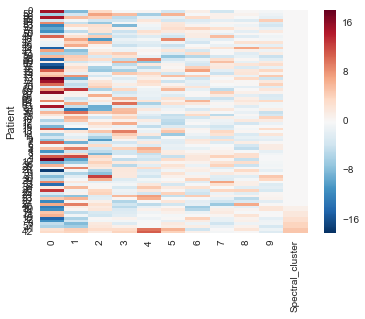

In [211]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
spectral_final = SpectralClustering(n_clusters=6)
spectral_final = spectral_final.fit(processed_numerical_p50_imputed)
spectral_plot = pd.DataFrame(processed_numerical_p50_imputed)
spectral_plot['Spectral_cluster'] = spectral_final.labels_
spectral_plot.sort('Spectral_cluster',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
spectral_plot.index.name = 'Patient'
sb.heatmap(spectral_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!
 
## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!

# Gaussian Mixture Models

In [203]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6]
 
def compare_GMM(k_list,data):
    ## Run clustering with different k and check the metrics
    s_scores, h_scores, r_scores = [], [], []
    
    for k in k_list:
        clusterer = GaussianMixture(n_components=k)
        clusterer.fit(data)
        labels = clusterer.predict(data)
        silhouette = metrics.silhouette_score(data, labels)
        homogeneity = metrics.homogeneity_score(processed['PAM50 mRNA'], labels)
        rand = metrics.adjusted_rand_score(processed['PAM50 mRNA'], labels)

        s_scores.append(silhouette)
        h_scores.append(homogeneity)
        r_scores.append(rand)
        
        ## The higher (up to 1) the better
        print "------------ k=",k, "--------"
        print "Silhouette Coefficient:", round(silhouette, 4)
        ## The higher (up to 1) the better
        print "Homogeneity score:", round(homogeneity,4)
        ## The higher (up to 1) the better
        print "Adjusted Rand Index", round(rand,4)
        print 
        
    return s_scores, h_scores, r_scores
 
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)
 
 
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
s_scores, h_scores, r_scores = compare_GMM(n_clusters,processed_numerical_p50_imputed)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
# compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

print
print("------------Results------------")

print "k with highest silhouette coefficient:", n_clusters[np.array(s_scores).argmax()], np.max(s_scores)
print "k with highest homogeneity score:", n_clusters[np.array(h_scores).argmax()], np.max(h_scores)
print "k with adjusted rand index score:", n_clusters[np.array(r_scores).argmax()], np.max(r_scores)

------------ k= 2 --------
Silhouette Coefficient: 0.2522
Homogeneity score: 0.2234
Adjusted Rand Index 0.2421

------------ k= 3 --------
Silhouette Coefficient: 0.2094
Homogeneity score: 0.412
Adjusted Rand Index 0.3784

------------ k= 4 --------
Silhouette Coefficient: 0.1253
Homogeneity score: 0.3455
Adjusted Rand Index 0.25

------------ k= 5 --------
Silhouette Coefficient: 0.1755
Homogeneity score: 0.4764
Adjusted Rand Index 0.369

------------ k= 6 --------
Silhouette Coefficient: 0.1669
Homogeneity score: 0.4847
Adjusted Rand Index 0.2843


------------Results------------
k with highest silhouette coefficient: 2 0.252193427737
k with highest homogeneity score: 6 0.484670472646
k with adjusted rand index score: 3 0.378389393957


In [204]:
gmm_metrics = np.array([s_scores, h_scores, r_scores])
pd.DataFrame(gmm_metrics, columns=["k = "+str(k) for k in n_clusters], index=["Silhouette Coeff.", "Homogeneity Score", "Adjusted Rand Index"])

k = 2     k = 3     k = 4     k = 5     k = 6
Silhouette Coeff.    0.252193  0.209404  0.125254  0.175469  0.166854
Homogeneity Score    0.223388  0.412024  0.345453  0.476410  0.484670
Adjusted Rand Index  0.242112  0.378389  0.249985  0.369010  0.284254

/Users/RichardChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


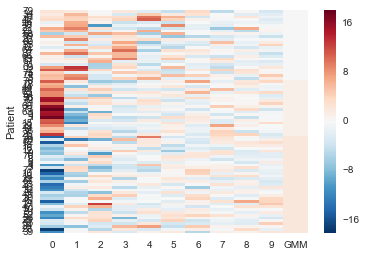

In [205]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
gmm_final = GaussianMixture(n_components=3)
gmm_final = gmm_final.fit(processed_numerical_p50_imputed)
gmm_plot = pd.DataFrame(processed_numerical_p50_imputed)
gmm_plot['GMM'] = gmm_final.predict(processed_numerical_p50_imputed)
gmm_plot.sort('GMM',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
gmm_plot.index.name = 'Patient'
sb.heatmap(gmm_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!
 
## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!